<h1 style="font-size: 25px; color: blue;">3 - Bifurcation diagram plots</h1>

<br>Contact: guillaumegirier@gmail.com</br>

<br>Commun work: Guillaume Girier, Isa Dallmer-Zerbe, Helmut Schmidt</br>

In this notebook, we generate a 3D bifurcation diagram in the $\{[K+]o,[Na+]i,V\}$ phase space, derived from the fast subsystem equations. This bifurcation diagram provides a detailed view of the system's dynamical structure, highlighting the transitions between different states as governed by the interplay of extracellular potassium [K+]o, intracellular sodium [Na+]i, and membrane potential V. Using the bifurcation tool XPPAUT, we compute the bifurcation surfaces (the data is available in the file "dia_bif.dat", and the code to produce it is named "Epileptor2_fastsub.ode"), which are overlaid with a non-stimulated solution trajectory obtained from the full system equations.


<h1 style="font-size: 25px; color: blue;">Library importations :</h1>


In [1]:
#%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

<h1 style="font-size: 25px; color: blue;">Defining functions :</h1>

<h1 style="font-size: 22px; color: red;"> LFES spike train function :</h1>


In [2]:
def generate_periodic_spike_train(total_time, spike_count, dt):
    time = np.arange(0, total_time, dt)
    spike_train = np.zeros_like(time)

    # Calculer les intervalles entre chaque train de spike
    inter_spike_interval = int(1/(dt*Hz))

    # Générer les trains de spikes
    for i in range(spike_count):
        spike_train[i * inter_spike_interval] = 1

    return spike_train

<h1 style="font-size: 22px; color: red;"> Epileptor-2 model function :</h1>


In [3]:
# Epileptor-2 parameter values

Kbath=8.5
gamma=10.0
deltaKo=0.02
deltaNai=0.03
Ko0=3.0
Nai0=10.0

factor = 1.75
tauK=10.0*factor
tauNa=20.0*factor
rho=0.2/factor
taum=0.002  
taux=2.0
deltax=0.01

G_syn=0.3
vmax= 75.0

Vth=10.0

gle=1.0
gKe=0.5

##############################

# Noise activation : 0/1

sigma=0


##############################

# Connection with the inactive population

I0 = 0
Vsyn = -15
Ssyn = 1
gsyn = 0.1686

eps = 0.03

##############################

# Setting the stimulation time

Hz = 1
A = 30
stim_size = 2500
space = 59
ini_1 = 4800
ini_2 = ini_1 + stim_size

##############################

# Define auxiliary functions

def         vi(V): return vmax*1./(1+np.exp(Vth-V))
def    ue(V,xD,Ko): return gKe*26.6*np.log(Ko/Ko0)+G_syn*vi(V)*xD+ sigma * np.random.normal(0, 1) 
def Ipump(Ko,Nai): return rho/((1+np.exp(3.5-Ko))*(1+np.exp((25.0-Nai)/3)))

##############################

# Main function

def my_epileptor_2(t_eval, dt, ini):
    
       
    Ve  = np.zeros(len(t_eval))
    xDe = np.zeros(len(t_eval))
    Koe = np.zeros(len(t_eval))
    Naie= np.zeros(len(t_eval))
    
    I  = np.zeros(len(t_eval))
    
    Ve[0]  =ini[0]
    xDe[0] =ini[1]
    Koe[0] =ini[2]
    Naie[0]=ini[3]
    
    for i in range(1, len(t_eval)):
        
        if statut == True:
            if t_eval[i]>ini_1 and t_eval[i]<ini_2:
                I[i]  = A*Itrain[i]
            #elif t_eval[i]>ini_1+space and t_eval[i]<ini_2+space:
            #    I[i]  = A*Itrain[i]
            #elif t_eval[i]>ini_1+space*2 and t_eval[i]<ini_2+space*2:
            #    I[i]  = A*Itrain[i]
            #elif t_eval[i]>ini_1+space*3 and t_eval[i]<ini_2+space*3:
            #    I[i]  = A*Itrain[i]
            else:
                I[i]  = 0
        else:
            I[i]  = 0
            
        
            
        Isyne = gsyn * Ssyn * (Vsyn - Ve[i-1])
    
        Ve[i]  = Ve[i-1] + dt *( (ue(Ve[i-1],xDe[i-1],Koe[i-1])-gle*Ve[i-1]+ Isyne +I[i-1])/taum  )
        xDe[i] = xDe[i-1] + dt *( (1-xDe[i-1])/taux-deltax*xDe[i-1]*vi(Ve[i-1]) )
        Koe[i] = Koe[i-1] + dt * eps * ( (Kbath-Koe[i-1])/tauK-2*gamma*Ipump(Koe[i-1],Naie[i-1])+deltaKo*vi(Ve[i-1]))
        Naie[i]= Naie[i-1] + dt * eps * ( (Nai0-Naie[i-1])/tauNa-3*Ipump(Koe[i-1],Naie[i-1])+deltaNai*vi(Ve[i-1]) )
                
    return np.array([Ve, xDe, Koe, Naie, I])

<h1 style="font-size: 25px; color: blue;">Simulations :</h1>

<h1 style="font-size: 22px; color: red;"> Model without LFES effect simulation :</h1>


In [4]:
S0=np.array([25.0, 0.7, 3.0, 5.0])            # Initial conditions : V, xD, Ko, Na 
t_span = (0, 10000)                           # Time span for simulation
dt=0.001
statut = False                                # Choosing if we apply or not the LFES : True = LFES / False = no LFES
t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
sol = my_epileptor_2(t_eval, dt, S0)          # Simulation


<h1 style="font-size: 22px; color: red;"> Saving the time series into variables:</h1>


In [5]:

VVe_ref = sol[0]
XXe_ref = sol[1]
KKe_ref = sol[2]
NNae_ref = sol[3]
I_ref = sol[4]
T_ref = t_eval

<h1 style="font-size: 25px; color: blue;">Plotting the results:</h1>

<h1 style="font-size: 22px; color: red;"> Loading the bifurcation diagram:</h1>


In [6]:
Full_Data = []

with open(r"dia_bif.dat") as datFile:
    Full_Data.append([data.split() for data in datFile])

    
Full_Data = np.float64(np.squeeze(Full_Data).T)


print(np.shape(Full_Data))

(5, 2000)


<h1 style="font-size: 22px; color: red;"> Overlaying the $\{K,V\}$ bifurcation diagram with a time series :</h1>

<h1 style="font-size: 18px; color: green;"> Bifurcation points:</h1>

The black dots denote the fold bifurcation points.

The green dot denotes the Hopf bifurcation point.

<h1 style="font-size: 18px; color: green;"> Steady-states curve:</h1>

The cyan curve denotes the ictal phase of the bifurcation diagram (stable states).

The red curve denotes the interictal phase (stable states).

The thick black curve denotes the unstable states.

<h1 style="font-size: 18px; color: green;"> Time series:</h1>

The thin black curve denotes the time series.

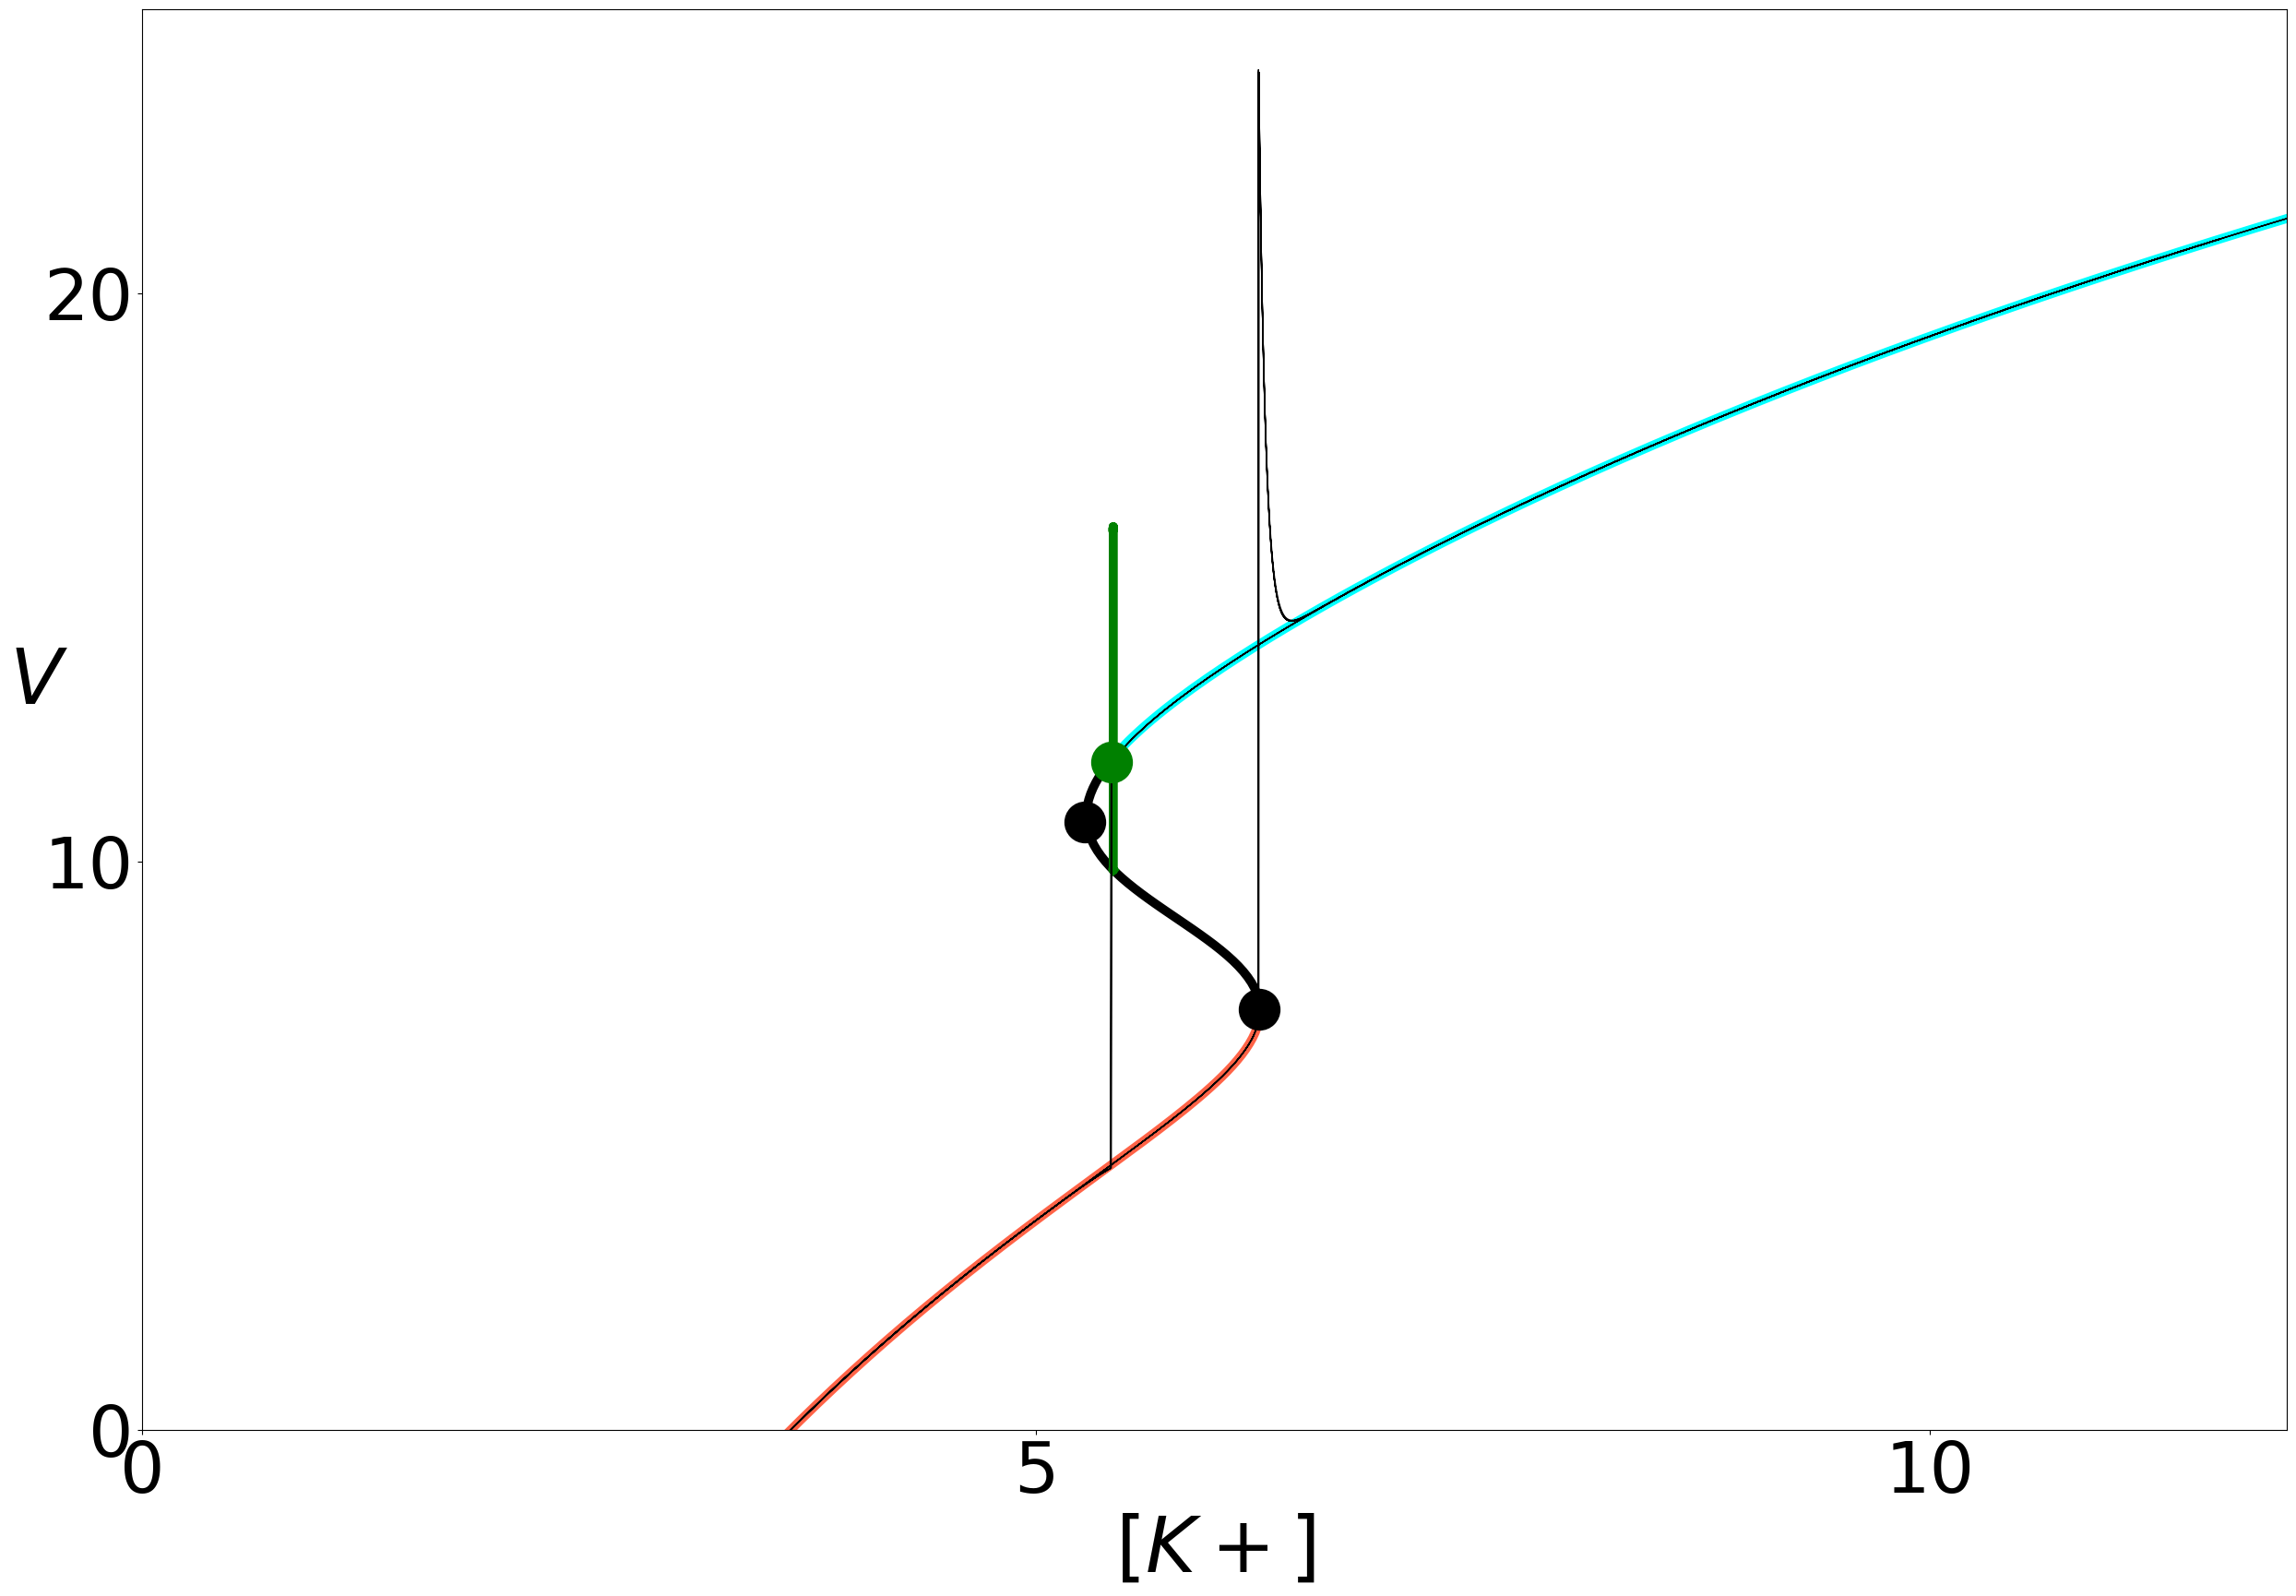

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(30,20)) 
ax = fig.gca()


plt.plot(Full_Data[0][:227], Full_Data[1][:227], color ='tomato', alpha = 1, linewidth=7)
plt.plot(Full_Data[0][227:274], Full_Data[1][227:274], color ='k', alpha = 1, linewidth=7)
plt.plot(Full_Data[0][274:500], Full_Data[1][274:500], color ='cyan', alpha = 1, linewidth=7)

plt.plot(Full_Data[0][1000:1500], Full_Data[1][1000:1500], color ='g', alpha = 1, linewidth=7)
plt.plot(Full_Data[0][1000:1500], Full_Data[2][1000:1500], color ='g', alpha = 1, linewidth=7)

plt.scatter(5.42, 11.75, marker="o", c="g", s=1000, zorder = 100)
plt.scatter(6.25, 7.4, marker="o", c="k", s=1000, zorder = 100)
plt.scatter(5.27, 10.7, marker="o", c="k", s=1000, zorder = 100)

plt.plot(KKe_ref[100000:], VVe_ref[100000:], c='k', alpha = 1, linewidth = 1)


#plt.plot(KK1[10000:25000], VV1[10000:25000], "k", alpha = 1, linewidth = 2, label = "Reference signal")

plt.savefig('FIG_2_C.eps', format='eps', dpi=300)

plt.rc('text', usetex=True)

plt.xlim([0, 12])
plt.ylim([0,25])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelsize=55)
ax.tick_params(axis='y', labelsize=55)
xLabel = ax.set_xlabel('$[K+]$', linespacing=3, fontsize=60)
yLabel = ax.set_ylabel('$V$',  rotation=0, linespacing=3, fontsize=60)
ax.dist = 10
#plt.legend(prop={'size': 35})
#plt.title("Morris-Lecar bifurcation diagram")
plt.savefig("New_Fig_bif2D.svg", format='svg')
plt.show()

<h1 style="font-size: 22px; color: red;"> Defining the surfaces in 3D :</h1>


In [8]:
LIN_Na = np.linspace(10,42, 6000)

LIN_K_1 = np.copy(Full_Data[0][50:227])
LIN_V_1 = np.copy(Full_Data[1][50:227])

SUR_K_1, SUR_Na_1 = np.meshgrid(LIN_K_1, LIN_Na)
SUR_V_1, SUR_Na_1 = np.meshgrid(LIN_V_1, LIN_Na)

###############################################

LIN_K_2 = np.copy(Full_Data[0][227:274])
LIN_V_2 = np.copy(Full_Data[1][227:274])

SUR_K_2, SUR_Na_2 = np.meshgrid(LIN_K_2, LIN_Na)
SUR_V_2, SUR_Na_2 = np.meshgrid(LIN_V_2, LIN_Na)

###############################################

LIN_K_3 = np.copy(Full_Data[0][274:400])
LIN_V_3 = np.copy(Full_Data[1][274:400])

SUR_K_3, SUR_Na_3 = np.meshgrid(LIN_K_3, LIN_Na)
SUR_V_3, SUR_Na_3 = np.meshgrid(LIN_V_3, LIN_Na)

###############################################

LIN_K_4 = np.copy(Full_Data[0][1000:1500])
LIN_V_4 = np.copy(Full_Data[1][1000:1500])

SUR_K_4, SUR_Na_4 = np.meshgrid(LIN_K_4, LIN_Na)
SUR_V_4, SUR_Na_4 = np.meshgrid(LIN_V_4, LIN_Na)

###############################################

LIN_K_5 = np.copy(Full_Data[0][1000:1500])
LIN_V_5 = np.copy(Full_Data[2][1000:1500])

SUR_K_5, SUR_Na_5 = np.meshgrid(LIN_K_5, LIN_Na)
SUR_V_5, SUR_Na_5 = np.meshgrid(LIN_V_5, LIN_Na)


<h1 style="font-size: 22px; color: red;"> Overlaying the $\{K, Na, V\}$ bifurcation diagram with a time series :</h1>


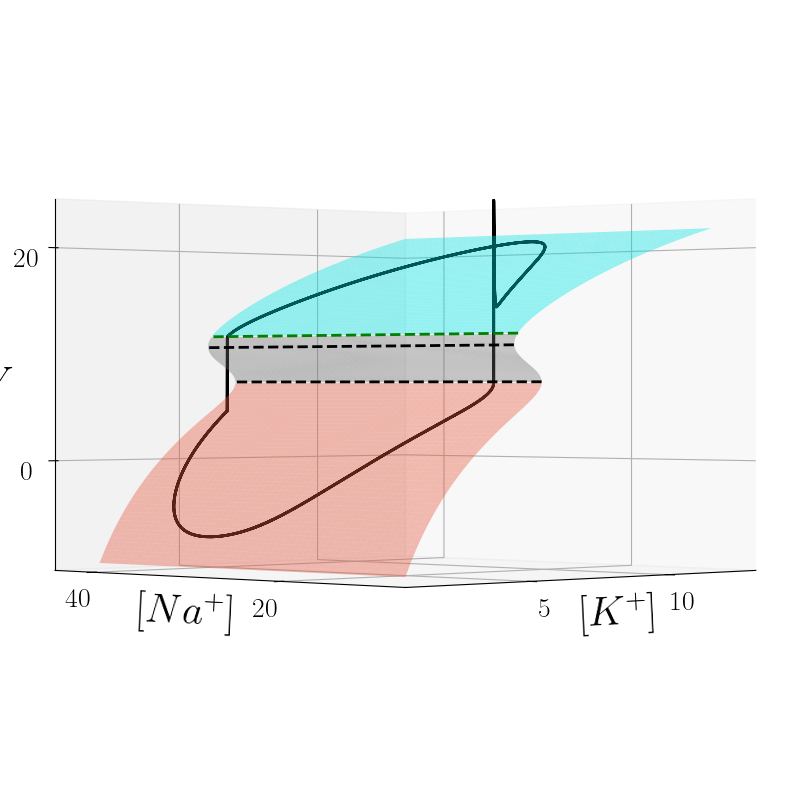

In [10]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')  

surf = ax.plot_surface(SUR_K_1, SUR_Na_1, SUR_V_1, alpha= 0.4, 
                       color ='tomato', edgecolor='none',
                       antialiased=True)

surf = ax.plot_surface(SUR_K_2, SUR_Na_2, SUR_V_2, alpha= 0.4, 
                       color ='Grey', edgecolor='none',
                       antialiased=True)


surf = ax.plot_surface(SUR_K_3, SUR_Na_3, SUR_V_3, alpha= 0.4, 
                       color ='cyan', edgecolor='none',
                       antialiased=True)

"""
surf = ax.plot_surface(SUR_K_4, SUR_Na_4, SUR_V_4, alpha= 0.4, 
                       color ='Green', edgecolor='none',
                       antialiased=True)


surf = ax.plot_surface(SUR_K_5, SUR_Na_5, SUR_V_5, alpha= 0.4, 
                       color ='Green', edgecolor='none',
                       antialiased=True)
"""
plt.plot(5.42*np.ones(len(LIN_Na)), LIN_Na, 11.75*np.ones(len(LIN_Na)), "g--",  zorder = 100, linewidth=2)
plt.plot(6.25*np.ones(len(LIN_Na)), LIN_Na, 7.4*np.ones(len(LIN_Na)), "k--",  zorder = 100, linewidth=2)
plt.plot(5.27*np.ones(len(LIN_Na)), LIN_Na, 10.7*np.ones(len(LIN_Na)), "k--", zorder = 100, linewidth=2)


#VV_ref[VV_ref>60]=60
#VV1[VV1>60]=60

plt.plot(KKe_ref [2000000:], NNae_ref [2000000:], VVe_ref [2000000:], "k-", alpha = 1, linewidth = 2)

#plt.plot(KK_ref[3200:6500], NNa_ref[3200:6500], VV_ref[3200:6500], "r--", alpha = 0.5, linewidth = 2, label="No stim")

#ax.grid(False)
#plt.axis('off')

plt.rc('text', usetex=True)

plt.locator_params(axis="x", nbins=2)
plt.locator_params(axis="y", nbins=2)
plt.locator_params(axis="z", nbins=2)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)
xLabel = ax.set_xlabel('$[K^+]$', linespacing=3, fontsize=30)
yLabel = ax.set_ylabel('$[Na^+]$', linespacing=3, fontsize=30)
zLabel = ax.set_zlabel('$V$', linespacing=3, fontsize=30)
ax.view_init(elev=0, azim=-135)  # Par exemple, élévation de 30° et azimut de 45°
plt.savefig("New_Fig_bif3D.svg", format='svg')
plt.show()
